<a href="https://colab.research.google.com/github/KJOELJOYSON2427/NLP_SENTIMENTAL_ANALYSIS/blob/main/sentimental_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer,ToktokTokenizer
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.naive_bayes import MultinomialNB
from string import punctuation
from nltk.stem import WordNetLemmatizer
import os
pd.set_option('display.float_format', lambda x: '%.3f' % x)

ImportError: cannot import name 'interp' from 'scipy' (/usr/local/lib/python3.12/dist-packages/scipy/__init__.py)

In [6]:
!pip install scikit-plot

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer,ToktokTokenizer
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.naive_bayes import MultinomialNB
from string import punctuation
from nltk.stem import WordNetLemmatizer
import os
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [11]:
df=pd.read_csv("/content/Womens Clothing E-Commerce Reviews.csv")


In [12]:
df.head(2)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses


In [14]:
df =df[['Review Text','Recommended IND']]
df

,Review Text,Recommended IND
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1
...,...,...
23481,I was very happy to snag this dress at such a ...,1
23482,"It reminds me of maternity clothes. soft, stre...",1
23483,"This fit well, but the top was very see throug...",0
23484,I bought this dress for a wedding i have this ...,1


In [15]:
#Get Dimension of the Data
df.shape

(23486, 2)

In [17]:
df.rename(columns={
    'Review Text':'review_text','Recommended IND':'recommended'
}, inplace=True)

In [18]:
df.head(2)

,review_text,recommended
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1


In [22]:
#Checking and Handling Missing Values
df.isna().sum()

,0
review_text,845
recommended,0


In [23]:
df['review_text']= df['review_text'].fillna(' ')

In [24]:
df.isna().sum()

,0
review_text,0
recommended,0


In [26]:
df.dtypes

,0
review_text,object
recommended,int64


In [28]:
#Exploratory Data Analysis (EDA)
df.loc[df["recommended"] == 0, "recommended"]= "Not Recommended" # 0 -> Not Recommended
df.loc[df["recommended"] == 1, "recommended"] = "Recommended" # 1 -> Recommended

In [29]:
df.dtypes

,0
review_text,object
recommended,object


In [31]:
#Check Proportion Target Class Variable
count_class = df.value_counts(df["recommended"],sort=True)

In [32]:
count_class

,count
recommended,
Recommended,19314
Not Recommended,4172


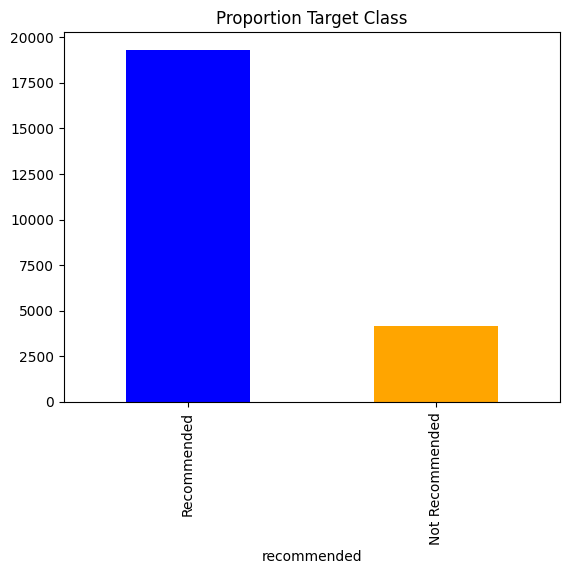

In [34]:
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Class')
plt.show()

In [39]:
print('Recommended', round(df['recommended'].value_counts()['Recommended']/df.shape[0]*100), '%')

Recommended 82 %


In [41]:
print('Not Recommended', round(df['recommended'].value_counts()['Not Recommended']/df.shape[0]*100), '%')

Not Recommended 18 %


In [42]:
#Check Most Common Words in Each Target Variable Values
count1 =Counter(" ".join(df[df['recommended']=="Recommended"]['review_text']).\
                split()).most_common(20)

In [43]:
count1

[('the', 58954),
 ('i', 40789),
 ('and', 40389),
 ('a', 35828),
 ('it', 29788),
 ('is', 25523),
 ('to', 19767),
 ('this', 16676),
 ('in', 16506),
 ('but', 12601),
 ('for', 11337),
 ('with', 11250),
 ('on', 10795),
 ('of', 10512),
 ('so', 9453),
 ('my', 9024),
 ('was', 7955),
 ('that', 7462),
 ('I', 6964),
 ('not', 6944)]

In [46]:
df1 = pd.DataFrame.from_dict(count1)
df1

,0,1
0,the,58954
1,i,40789
2,and,40389
3,a,35828
4,it,29788
5,is,25523
6,to,19767
7,this,16676
8,in,16506
9,but,12601


In [49]:
df1=df1.rename(columns={
    0:"commom_words", 1:"cout"
})
df1.head(10)

,commom_words,cout
0,the,58954
1,i,40789
2,and,40389
3,a,35828
4,it,29788
5,is,25523
6,to,19767
7,this,16676
8,in,16506
9,but,12601


In [51]:
count2 = Counter(" ".join(df[df['recommended']== 'Not Recommended']['review_text']).\
                 split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)

In [52]:
df2 = df2.rename(columns={0: "common_words", 1 : "count"})
df2.head(10)

,common_words,count
0,the,15744
1,i,8841
2,and,8116
3,it,7514
4,a,6804
5,is,4799
6,to,4547
7,was,4137
8,this,4050
9,in,3705


In [55]:
df.iloc[1,0]

'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

Text Mining

In [58]:
tokenizer =ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english'
)
stopword_list

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [57]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [59]:
main_text = df['review_text']
target = df['recommended']

print(len(main_text))
print(len(target))

23486
23486


In [62]:
contractions_dict = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
                           "how's": "how is",
"I'd": "I had",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "iit will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they will",
                           "they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
                           "they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have"
}


SyntaxError: invalid syntax (ipython-input-1800105528.py, line 1)